```
This software is part of GPU Ocean. 

Copyright (C) 2018, 2019 SINTEF Digital
Copyright (C) 2018, 2019 Norwegian Meteorological Institute

Checking a bug in the Coriolis decomposition


This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Checking a bug in the Coriolis decomposition

## Import modules and set up environment

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc, colors, cm
from matplotlib import pyplot as plt

import os
import datetime
import gc
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(6.0, 4.0))
rc('animation', html='html5')
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

#Import our simulator
from SWESimulators import CDKLM16, OceanStateNoise, PlotHelper, Common, IPythonMagic
#Import initial condition and bathymetry generating functions:
from SWESimulators.BathymetryAndICs import *

In [2]:
%cuda_context_handler gpu_ctx

In [3]:
width = 500000
height = 500000

domain_size = 180
    
g = 9.81
r = 0.00
f = 1.0e-4
beta = 1.0e-11

end_time = 1600.0

In [35]:

def getNorthPole():
    #North pole
    x0 = 0.5
    y0 = 4
    return x0, y0


def initAngle(angle):
    ny, nx = angle.shape
    
    #North pole
    x0, y0 = getNorthPole()
    
    #Vector to north
    x = np.linspace(-1, 1, nx) - x0
    y = np.linspace(-1, 1, ny) - y0
    x, y = np.meshgrid(x, y)
    
    #Normalize
    l = np.sqrt(x**2 + y**2)
    x = x/l
    y = y/l
    
    angle.fill(-np.pi/2)
    angle = angle + np.arccos(x)
    
    return angle

def initLatitude(lat):
    ny, nx = lat.shape
    
    x0, y0 = getNorthPole()
    
    #Distance to north pole
    x = (np.linspace(-1, 1, nx) - x0)*width/2
    y = (np.linspace(-1, 1, ny) - y0)*height/2
    x, y = np.meshgrid(x, y)
    
    # The distance between latitudes are 111.2 km
    # Numbers of latitudes from the north pole
    l = np.sqrt(x**2 + y**2)/111200
    
    lat = 90 - l
    return lat
    



    

## CDKLM 16

latitude min and max:  78.26404394232178 83.25539288626489
Angle: Max=0.46365, min=-0.16515, sum=0.1298151733


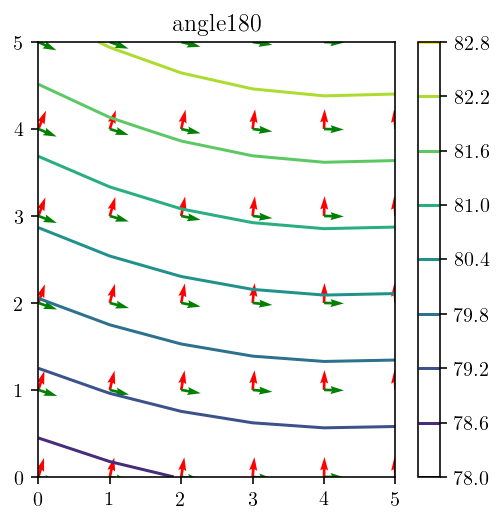

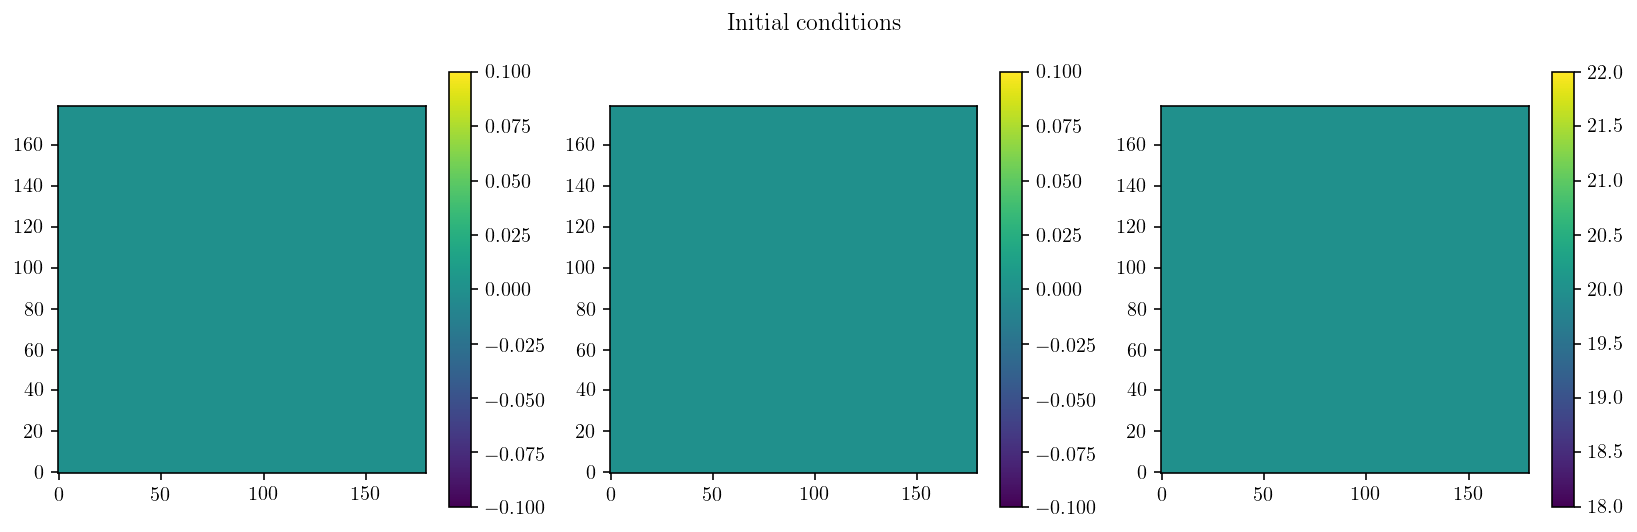

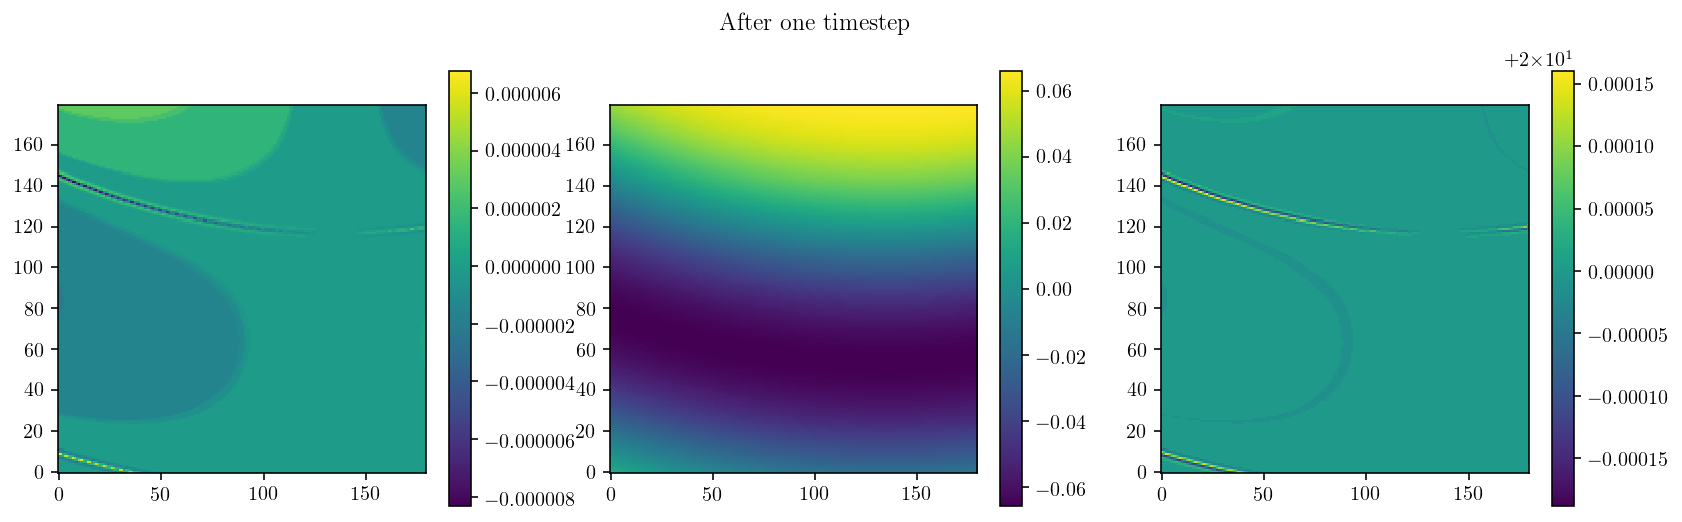

In [36]:
#Clean up old simulator if any:
if 'sim' in globals():
    sim.cleanUp()

nx = domain_size
ny = domain_size

dx = float(width/nx)
dy = float(height/ny)

#bc = Common.BoundaryConditions(3,3,3,3, spongeCells=[2,2,2,2])
bc = Common.BoundaryConditions(2,2,2,2)
ghosts = np.array([2,2,2,2])
dataShape = (ny + ghosts[1]+ghosts[3], 
             nx + ghosts[0]+ghosts[2])

Hi_flat = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32)*60
eta0 = np.zeros(dataShape, dtype=np.float32);
hu0 = np.zeros(dataShape, dtype=np.float32);
hv0 = np.zeros(dataShape, dtype=np.float32);
angle = np.zeros(dataShape, dtype=np.float32);
dt = end_time / domain_size

angle=initAngle(angle)

lat = np.zeros(dataShape, dtype=np.float32)
lat = initLatitude(lat)
print('latitude min and max: ', lat.min(), lat.max())
   
plt.figure(figsize=(4,4))

plt.quiver(np.sin(angle[::32, ::32]), np.cos(angle[::32, ::32]), color='r')
plt.quiver(np.cos(angle[::32, ::32]), -np.sin(angle[::32, ::32]), color='g')
plt.title("angle"+str(domain_size))
print("Angle: Max={:.05f}, min={:.05f}, sum={:.010f}".format(np.max(angle), np.min(angle), np.sum(angle/(domain_size*domain_size))))
plt.contour(lat[::32, ::32])
plt.colorbar()



    
# Constant hv:
hv0 = hv0 + 20

f_zero = 0

#Initialize simulator
sim = CDKLM16.CDKLM16(gpu_ctx, 
                      eta0, hu0, hv0, Hi_flat,
                      nx, ny, 
                      dx, dy, 0, 
                      g, f_zero, r, 
                      subsample_angle=None,
                      subsample_f=None,
                      #coriolis_beta=beta,
                      latitude=lat,
                      boundary_conditions=bc,
                      rk_order=1,
                      angle=angle)


def plotImshow(data, title=' '):
    fig = plt.figure(figsize=(5,4))
    plt.imshow(data, origin='lower', interpolation='None')
    plt.colorbar()
    plt.title(title)
    
def plotImshow3(eta, hu, hv, title=' '):
    fig = plt.figure(figsize=(14, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(eta, origin='lower', interpolation='None')
    plt.colorbar()
    plt.subplot(1, 3, 2)
    plt.imshow(hu, origin='lower', interpolation='None')
    plt.colorbar()
    plt.subplot(1, 3, 3)
    plt.imshow(hv, origin='lower', interpolation='None')
    plt.colorbar()
    plt.suptitle(title)
    
eta1, hu1, hv1 = sim.download(interior_domain_only=True)
plotImshow3(eta1, hu1, hv1, title='Initial conditions')

sim.step(sim.dt)

eta1, hu1, hv1 = sim.download(interior_domain_only=True)
plotImshow3(eta1, hu1, hv1, 'After one timestep')



#### Notes

With the buggy code, the resulting ocean state contains a clear and distinct grid according to the block decomposition,
with values that vary based on the angle to north. You should see the bug by copying this notebook into any earlier version of the code.

With the fix, you should get $hv=2$ (as initial conditions), but $hu$ should get values that resemble the cells' latitudes.


In eta, I still get a small buble in the the top of the domain (of the order 1e-7). I don't know what causes this, and it does not look directly good... However, that has to be for another time.

In [7]:
def test(a, b=2, c=3, d=4):
    print(a, b, c, d)
    
test(1)


1 2 3 4
